In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from numba import njit  # (Optional) uncomment if you have numba installed

: 

# 1. SIMULATION PARAMETERS

In [153]:
# Physical constants (SI)
q_e      = 1.60217662e-19  # elementary charge [C]
mass_ion = 69 * 1.660e-27        # example: ~Ga69 ion mass [kg]

# Beam parameters
N_PART   = 50000           # number of macro-particles
sigma_x  = 1.0e-4        # RMS beam size in x [m]
sigma_y  = 1.0e-4          # RMS beam size in y [m]
sigma_xp = 5.0e-3    # RMS slope x' (in rad)
sigma_yp = 5.0e-3        # RMS slope y' (in rad)
v_z      = 1.0e5           # axial velocity [m/s] (non-relativistic assumption)

# Quadrupole region
z_start  = 0.00             # start of quadrupole [m]
z_end    = 0.006         # end of quadrupole   [m]

# -- TUNABLE QUADRUPOLE--
# A1 -> amplitude for the standard (x^2 - y^2) mode
# A2 -> amplitude for the rotated mode (2 x y)
A1 = 0 #-30.0e7
A2 = 0 #30e6#1.0e7# Try turning this on/off to see rotation

# -- TUNABLE Octopole--
A_octo1 = 1e7
A_octo2 = 0 # Try turning this on/off to see rotation

# Simulation extent
z_max    = 0.03
N_steps  = 2000
dz       = z_max / N_steps
dt       = dz / v_z   # time step for Euler integration

# Planes at which to record beam cross-sections
z_planes = [0.0, 0.002, 0.004, 0.006, 0.008, 0.05]#0.006, 0.3]




: 

# 2. GENERATE INITIAL BEAM

In [154]:
np.random.seed(42)  # for reproducibility

# Positions
x_init  = np.random.normal(0.0, sigma_x,  size=N_PART)
y_init  = np.random.normal(0.0, sigma_y,  size=N_PART)

# Slopes (x', y'), then convert to velocities
xp_init = np.random.normal(0.0, sigma_xp, size=N_PART)
yp_init = np.random.normal(0.0, sigma_yp, size=N_PART)

vx_init = xp_init * v_z
vy_init = yp_init * v_z

# State arrays
x  = x_init.copy()
y  = y_init.copy()
vx = vx_init.copy()
vy = vy_init.copy()
z  = np.zeros(N_PART, dtype=np.float64)

# 3. QUADRUPOLE FIELD (TWO ORTHOGONAL MODES)

## Potential:

$\begin{aligned}
\Phi_1 &= x^2 - y^2 \\
\Phi_2 &= 2xy
\end{aligned}$

## Combined Potential:
$ \Phi = A_1 \Phi_1 + A_2 \Phi_2$

## Electric Field:
$ \mathbf{E} = -\nabla \Phi $

### $E_x$ Component:

$\begin{aligned}
E_x &= - \frac{\partial}{\partial x} \left[A_1 (x^2 - y^2) + A_2 (2xy) \right] \\
    &= - \left[ A_1 (2x) + A_2 (2y) \right] \\
    &= -2 \left[ A_1 x + A_2 y \right]
\end{aligned}$


### $E_y$ Component:

$\begin{aligned}
E_y &= - \frac{\partial}{\partial y} \left[A_1 (x^2 - y^2) + A_2 (2xy) \right] \\
    &= - \left[ A_1 (-2y) + A_2 (2x) \right] \\
    &= 2 \left[ A_1 y - A_2 x \right]
\end{aligned}$



In [155]:


# @njit  # (Optional) If numba is available
def combined_quadrupole_field(xarr, yarr, zarr,
                              A1, A2, z0, z1):
    """
    Return (Ex, Ey) for a combined quadrupole potential
    Phi = A1*(x^2 - y^2) + A2*(2 x y).
    Field is nonzero only in [z0, z1].
    """
    # Boolean mask for particles inside the quadrupole
    inside = (zarr >= z0) & (zarr <= z1)

    Ex = np.zeros_like(xarr)
    Ey = np.zeros_like(yarr)

    idx_in = np.where(inside)[0]
    if idx_in.size == 0:
        return Ex, Ey  # no particles inside => zero field

    x_in = xarr[idx_in]
    y_in = yarr[idx_in]

    # Ex_in = -2 [A1*x + A2*y]
    # Ey_in =  2 [A1*y - A2*x]
    Ex_in = -2.0 * (A1 * x_in + A2 * y_in)
    Ey_in =  2.0 * (A1 * y_in - A2 * x_in)

    Ex[idx_in] = Ex_in
    Ey[idx_in] = Ey_in

    return Ex, Ey

In [156]:
##############################################################################
# 3. COMBINED OCTOPOLE FIELD (two orthogonal 4th-order modes)
##############################################################################

# Potential:
#   Phi_1(x,y) = (x^4 - 6 x^2 y^2 + y^4)
#   Phi_2(x,y) = 4 x^3 y - 4 x y^3
# Then total: Phi = A1*Phi_1 + A2*Phi_2
# E = -grad(Phi).

# @njit  # (Optional) JIT-compile if numba is available
def combined_octopole_field(xarr, yarr, zarr,
                            A1, A2, z0, z1):
    """
    Vectorized field calculation returning Ex, Ey for all particles.
    Field is nonzero only if z0 <= z <= z1 (inside stigmator region).
    
    A1, A2 : strengths for the two orthogonal octopole modes.
    """
    inside = (zarr >= z0) & (zarr <= z1)

    Ex = np.zeros_like(xarr)
    Ey = np.zeros_like(yarr)

    idx_in = np.where(inside)[0]
    if idx_in.size == 0:
        return Ex, Ey  # no particles inside => 0 field

    x_in = xarr[idx_in]
    y_in = yarr[idx_in]

    # dPhi_1/dx = 4 x^3 - 12 x y^2
    # dPhi_1/dy = -12 x^2 y + 4 y^3
    dPhi1_dx = 4.0*x_in**3 - 12.0*x_in*(y_in**2)
    dPhi1_dy = -12.0*(x_in**2)*y_in + 4.0*y_in**3

    # dPhi_2/dx = 12 x^2 y - 4 y^3
    # dPhi_2/dy = 4 x^3 - 12 x y^2
    dPhi2_dx = 12.0*x_in**2*y_in - 4.0*y_in**3
    dPhi2_dy = 4.0*x_in**3 - 12.0*x_in*(y_in**2)

    # E_1 = -grad(Phi_1) => (Ex1, Ey1)
    Ex1 = -dPhi1_dx
    Ey1 = -dPhi1_dy

    # E_2 = -grad(Phi_2) => (Ex2, Ey2)
    Ex2 = -dPhi2_dx
    Ey2 = -dPhi2_dy

    # Combine them
    Ex_in = A1*Ex1 + A2*Ex2
    Ey_in = A1*Ey1 + A2*Ey2

    Ex[idx_in] = Ex_in
    Ey[idx_in] = Ey_in

    return Ex, Ey

In [157]:
q_over_m = q_e / mass_ion

# @njit
def step_particles(x, y, vx, vy, z, dt, dz,
                   q_mass, A1, A2, z0, z1, quadrupole=True):
    """
    One Euler step through the quadrupole field (if within z0,z1).
    1) Compute (Ex, Ey) from combined_quadrupole_field
    2) a = (q/m)*E
    3) update vx, vy
    4) update x, y
    5) increment z by dz
    """
    if quadrupole:
        Ex, Ey = combined_quadrupole_field(x, y, z, A1, A2, z0, z1)
    else:
        Ex, Ey = combined_octopole_field(x, y, z, A1, A2, z0,z1)
    ax = q_mass * Ex
    ay = q_mass * Ey

    vx += ax * dt
    vy += ay * dt

    x += vx * dt
    y += vy * dt

    z += dz

# For storing snapshots
snapshots = {}
def record_snapshot(z_val):
    snapshots[z_val] = (x.copy(), y.copy())

# Record initial distribution
record_snapshot(0.0)


## Quadrupole Case ("verified ChatGPT")

### 1. Quadrupole Potential

For a quadrupole in 2D, the lowest-order potential is:

$ \Phi_{\text{quad}}(x,y) \propto x^2 - y^2 $

which focuses in one plane (say $x$) while defocusing in the orthogonal plane ($y$). To allow rotation of the quadrupole field, we add a second basis function $2xy$. Thus:

$ \Phi = A_1 (x^2 - y^2) + A_2 (2xy) $

We can interpret $(A_1, A_2)$ as two knobs that set the overall strength and rotation angle of the quadrupole:

- $ \Phi_1 = x^2 - y^2 \quad \Rightarrow \quad $ standard “vertical/horizontal” focusing
- $ \Phi_2 = 2xy \quad \Rightarrow \quad $ “rotated” focus/defocus by 45°

### 2. Field Calculation

From $ \mathbf{E} = -\nabla \Phi $, we get:

$ E_x = -\frac{\partial \Phi}{\partial x} = -2(A_1 x + A_2 y) $

$ E_y = -\frac{\partial \Phi}{\partial y} = 2(A_1 y - A_2 x) $

The code is vectorized to handle all particles simultaneously in a single NumPy array operation.

### 3. Hard-Edge Model

Similar to the octopole example, the field is only applied if a particle’s $z$-coordinate is within $[z_{\text{start}}, z_{\text{end}}]$. Outside that region, $ \mathbf{E} = 0 $ and the particles drift freely.

### 4. Tuning and Rotation

- Set $ A_1 $ to a positive or negative value for focusing in $x$ vs. $y$.
- Set $ A_2 \neq 0 $ to rotate the quadrupole by 45° or some other angle. You can interpret $\theta$ such that:

  $ \theta = \frac{1}{2} \tan^{-1} \left( \frac{A_2}{A_1} \right) $

  for small angles, or perform a more precise analysis if both $A_1$ and $A_2$ are large.


In [158]:
for istep in range(N_steps):
    z_mean = istep * dz
    step_particles(x, y, vx, vy, z, dt, dz,
                   q_over_m, A1, A2, z_start, z_end)
    z_next = (istep+1)*dz

    for zplane in z_planes:
        if z_mean < zplane <= z_next:
            record_snapshot(zplane)

# Record final plane if needed
if z_planes[-1] not in snapshots:
    record_snapshot(z_planes[-1])

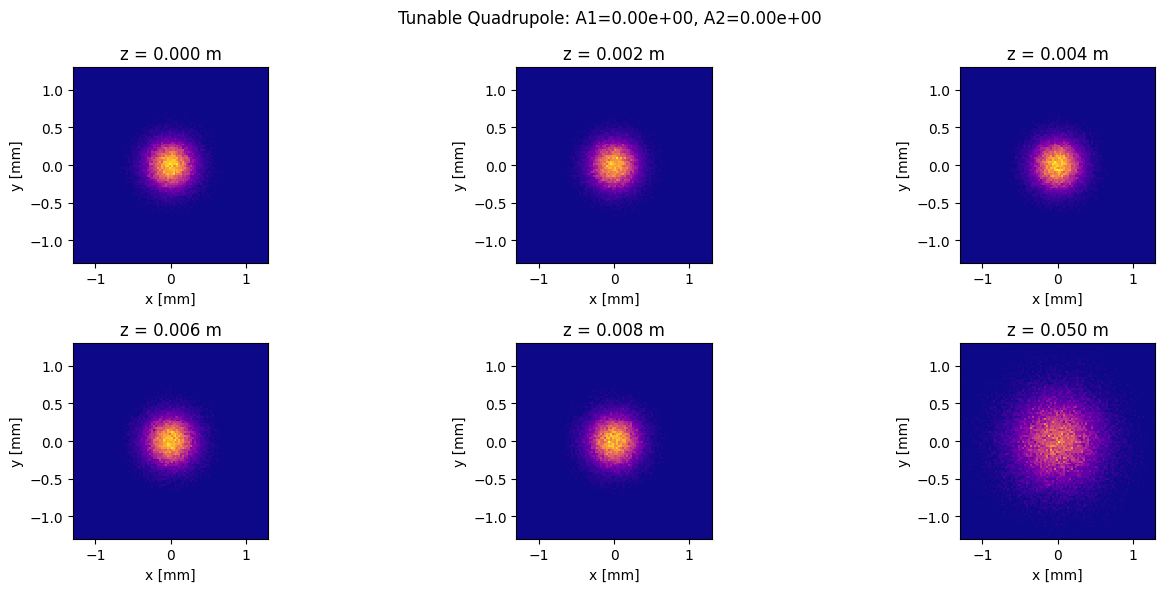

In [159]:
fig, axes = plt.subplots(2, (len(z_planes)+1)//2, figsize=(14,6), squeeze=False)
axes = axes.flatten()

for i, zpl in enumerate(z_planes):
    X, Y = snapshots[zpl]
    
    # 2D histogram in mm
    axes[i].hist2d(X*2e3, Y*2e3,
                   bins=100,
                   range=[[-1.3,1.3],[-1.3,1.3]],
                   cmap='plasma')
    axes[i].set_title(f"z = {zpl:.3f} m")
    axes[i].set_xlabel("x [mm]")
    axes[i].set_ylabel("y [mm]")
    axes[i].set_aspect('equal')

fig.suptitle(f"Tunable Quadrupole: A1={A1:.2e}, A2={A2:.2e}")
fig.tight_layout()
plt.show()

## Octopole Case (ChatGPT)

### How It Works

#### 1. Two Orthogonal Octopole Modes

We define two orthogonal 4th-order polynomials:

$\Phi_1 = x^4 - 6x^2y^2 + y^4$

$\Phi_2 = 4x^3y - 4xy^3$

These correspond to the standard $\cos(4\theta)$ and $\sin(4\theta)$ modes in polar coordinates. By assigning separate amplitudes $(A_1, A_2)$, we allow for tunable 4th-order astigmatism in two orthogonal directions/orientations.

#### 2. Combining the Fields

The total octopole potential is:

$\Phi_{\text{total}}(x,y) = A_1 \Phi_1(x,y) + A_2 \Phi_2(x,y).$

Since $\mathbf{E} = -\nabla \Phi$, the resulting $(E_x, E_y)$ is the linear combination of the gradients from $\Phi_1$ and $\Phi_2$.

#### 3. Tuning Astigmatism

- If $A_1 > 0$ and $A_2 = 0$, you get an octopole field aligned primarily along the $x$ and $y$ axes.
- If $A_1 = 0$ and $A_2 > 0$, the field is oriented at $45^\circ$ to the axes.
- Any combination $(A_1, A_2)$ produces a different orientation/strength of 4th-order astigmatism.

#### 4. Simulation Loop

- We use the same approach as before: Euler in $z$ steps.
- Within $[z_{\text{start}}, z_{\text{end}}]$, the field is applied. Outside it, the field is zero (perfect "hard-edge" model).
- We record snapshots of the beam at chosen planes $z_{\text{planes}}$.


In [16]:
A_octo1 = 0#1.0e15
A_octo2 = 2e15#1.0e5#1.0e9 # Try turning this on/off to see rotation 

np.random.seed(42)  # for reproducibility

# Positions
x_init  = np.random.normal(0.0, sigma_x,  size=N_PART)
y_init  = np.random.normal(0.0, sigma_y,  size=N_PART)

# Slopes (x', y'), then convert to velocities
xp_init = np.random.normal(0.0, sigma_xp, size=N_PART)
yp_init = np.random.normal(0.0, sigma_yp, size=N_PART)

vx_init = xp_init * v_z
vy_init = yp_init * v_z

# State arrays
x  = x_init.copy()
y  = y_init.copy()
vx = vx_init.copy()
vy = vy_init.copy()
z  = np.zeros(N_PART, dtype=np.float64)

In [17]:
for istep in range(N_steps):
    z_mean = istep * dz
    step_particles(x, y, vx, vy, z, dt, dz,
                   q_over_m, A_octo1, A_octo2, z_start, z_end, quadrupole=False)
    z_next = (istep+1)*dz

    for zplane in z_planes:
        if z_mean < zplane <= z_next:
            record_snapshot(zplane)

# Record final plane if needed
if z_planes[-1] not in snapshots:
    record_snapshot(z_planes[-1])

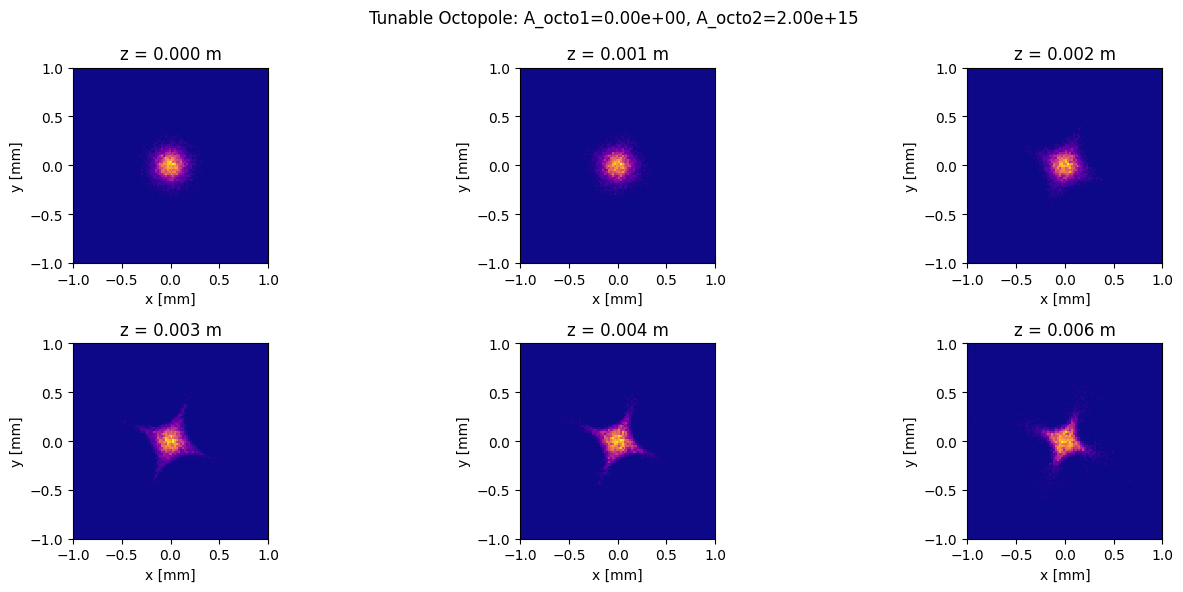

In [18]:
fig, axes = plt.subplots(2, (len(z_planes)+1)//2, figsize=(14,6), squeeze=False)
axes = axes.flatten()

for i, zpl in enumerate(z_planes):
    X, Y = snapshots[zpl]
    
    # 2D histogram in mm
    axes[i].hist2d(X*1e3, Y*1e3,
                   bins=100,
                   range=[[-1,1],[-1,1]],
                   cmap='plasma')
    axes[i].set_title(f"z = {zpl:.3f} m")
    axes[i].set_xlabel("x [mm]")
    axes[i].set_ylabel("y [mm]")
    axes[i].set_aspect('equal')

fig.suptitle(f"Tunable Octopole: A_octo1={A_octo1:.2e}, A_octo2={A_octo2:.2e}")
fig.tight_layout()
plt.show()